In [1]:
import numpy as np 
import matplotlib.pyplot as plt  
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import copy

import heapq
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from scipy.stats import wasserstein_distance

%matplotlib inline

torch.manual_seed(1337)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## IHDP Data Loading

In [3]:
class IHDPLoader(Dataset):
    '''
    Adapted from Causal Forge's DataLoader
    https://github.com/anthem-ai/causalforge/blob/main/causalforge/data_loader.py
    
    IHDP Data downloaded from Dr. Fredrik D. Johansson's website
    https://github.com/anthem-ai/causalforge/blob/main/causalforge/data_loader.py
    '''
    def __init__(self, is_train=True):
        super(IHDPLoader, self).__init__()
        self.is_train = is_train
        self.path_train = 'ihdp_npci_1-1000.train.npz'
        self.path_test = 'ihdp_npci_1-1000.test.npz'
        self.load()

    def load(self):
        # load
        if self.is_train:
            data = np.load(self.path_train)
        else:
            data = np.load(self.path_test)
    
        self.X    = torch.tensor(data.f.x.copy(), dtype=torch.float)
        self.T    = torch.tensor(data.f.t.copy(), dtype=torch.float)
        self.YF   = torch.tensor(data.f.yf.copy(), dtype=torch.float)
        self.YCF  = torch.tensor(data.f.ycf.copy(), dtype=torch.float)
        self.mu_0 = torch.tensor(data.f.mu0.copy(), dtype=torch.float)
        self.mu_1 = torch.tensor(data.f.mu1.copy(), dtype=torch.float)
        self.u = (self.T.mean(dim=0)).unsqueeze(0)
        self.w = (self.T / (2 * self.u)) + ((1 - self.T) / (2 * (1 - self.u))) 
        
        self.loaded = True
        
        return self.X, self.T, self.YF, self.YCF, self.mu_0, self.mu_1, self.u, self.w
    
    def __len__(self):
        if not self.loaded:
            self.load()
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if not self.loaded:
            self.load()
        return self.X[idx,:,:], self.T[idx,:], self.YF[idx,:], self.YCF[idx,:], self.mu_0[idx,:], self.mu_1[idx,:], self.w[idx,:]     

In [4]:
train_dataset = IHDPLoader(is_train=True)
test_dataset = IHDPLoader(is_train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

X_train, T_train, YF_train, YCF_train, mu_0_train, mu_1_train, u_train, w_train = train_dataset.load()
X_train.shape, T_train.shape, YF_train.shape, YCF_train.shape, mu_0_train.shape, mu_1_train.shape, u_train.shape, w_train.shape  

(torch.Size([672, 25, 1000]),
 torch.Size([672, 1000]),
 torch.Size([672, 1000]),
 torch.Size([672, 1000]),
 torch.Size([672, 1000]),
 torch.Size([672, 1000]),
 torch.Size([1, 1000]),
 torch.Size([672, 1000]))

In [5]:
print(len(train_loader))
print(len(test_loader))
train_iter = iter(train_loader)
train_batch = next(train_iter)

x_train, t_train, Yf_train, _, _, _, w_train = train_batch
x_train.shape, t_train.shape, Yf_train.shape, w_train.shape

21
2


(torch.Size([32, 25, 1000]),
 torch.Size([32, 1000]),
 torch.Size([32, 1000]),
 torch.Size([32, 1000]))

## Thoughts (can skip)

In [6]:
'''
// LOOKING AT THE DATA //

All of type numpy.ndarray
672 units
25 covariate features
1000 realizations of the outcomes, a realization = a simulation of the experiment 
AVERAGE OVER ALL 1000 REALIZATIONS
Each realization is a "separate dataset"

   X: [672, 25, 1000] 25 covariate features = aspects of children and their mothers
   T: [672, 1000] Treatment applied = SPECIALIST HOME VISIT, t \in {0, 1}
  YF: [672, 1000] Factual outcome = OBSERVED COGNITIVE TEST SCORE
 YCF: [672, 1000] Counterfactual outcome = COGNITIVE TEST SCORE we would've observed if they received the opposite treatment
mu_0: [672, 1000] Noiseless potential outcome 0 = COGNITIVE TEST SCORE if not treated, without any cofounding variable variation, theoretical baseline
mu_1: [672, 1000] Noiseless potential outcome 1 = COGINITIVE TEST SCORE if treated, without any cofounding variable variation, theoretical baseline

IHDP = Infant Health and Development Program
Covariates come from study of effects of SPECIALIST HOME VISITS on COGNITIVE TEST SCORES
Covariates = 25 aspects of children and their mothers

Follows the paper's 63/27/10 train/validation/test split
'''

'\n// LOOKING AT THE DATA //\n\nAll of type numpy.ndarray\n672 units\n25 covariate features\n1000 realizations of the outcomes, a realization = a simulation of the experiment \nAVERAGE OVER ALL 1000 REALIZATIONS\nEach realization is a "separate dataset"\n\n   X: [672, 25, 1000] 25 covariate features = aspects of children and their mothers\n   T: [672, 1000] Treatment applied = SPECIALIST HOME VISIT, t \\in {0, 1}\n  YF: [672, 1000] Factual outcome = OBSERVED COGNITIVE TEST SCORE\n YCF: [672, 1000] Counterfactual outcome = COGNITIVE TEST SCORE we would\'ve observed if they received the opposite treatment\nmu_0: [672, 1000] Noiseless potential outcome 0 = COGNITIVE TEST SCORE if not treated, without any cofounding variable variation, theoretical baseline\nmu_1: [672, 1000] Noiseless potential outcome 1 = COGINITIVE TEST SCORE if treated, without any cofounding variable variation, theoretical baseline\n\nIHDP = Infant Health and Development Program\nCovariates come from study of effects o

In [7]:
''' // CFR ALGORITHM //
Inputs:
    - 1 factual sample dataset                   ; dataset = {(x1, t1, y1), ..., (xN, tN, yN)}, N units
    - Scaling parameter                          ; \alpha = 1
    - Loss function                              ; L(..) = MSE Loss
    - Representation network w/ initial weights W; \Phi_W = 5-layer feed-forward NN
    - Hypothesis network w/ initial weights V    ; \h_V = 5-layer feed-forward NN
    - IPM function family, G                     ; Wasserstein distance
Outputs:
    - Training loss graph over all epochs of this representation dataset
    - Within-sample ITE for all units over both training and validation sets 
Algorithm:
average over K=1000 representations

Compute u = \frac{1}{N}\Sigma_{i=1}^{N} t_i # represents treated units proportion
Compute w_i = \frac{t_i}{2u} + \frac{1-t_i}{2(1-u)} # weights for the ith unit, w is a vector

while (not converged) do:
    Sample mini-batch {i1, i2, ..,, iM} from {1, 2, ..., N}
    
    ipm_loss = Wasserstein Distance # Calculate IPM term
    g1 = Calculate the gradient of the IPM term
    
    predicted_outcome = model.forward(x_i, t_i)    # h(\Phi(x_i), t_i)
    empirical_loss = MSE(predicted_outcome, y_i)   # Calculate the empirical loss
    g2 = gradient of h
    g3 = gradient of \Phi
    
    loss = \frac{1}{N}\Sigma_{i=1}^{N} w_i * empirical_loss + alpha * ipm_loss
    
    W <- W - lr * (alpha * g1 + g3)
    V <- V - lr * (g2 + 2V)
'''

' // CFR ALGORITHM //\nInputs:\n    - 1 factual sample dataset                   ; dataset = {(x1, t1, y1), ..., (xN, tN, yN)}, N units\n    - Scaling parameter                          ; \x07lpha = 1\n    - Loss function                              ; L(..) = MSE Loss\n    - Representation network w/ initial weights W; \\Phi_W = 5-layer feed-forward NN\n    - Hypothesis network w/ initial weights V    ; \\h_V = 5-layer feed-forward NN\n    - IPM function family, G                     ; Wasserstein distance\nOutputs:\n    - Training loss graph over all epochs of this representation dataset\n    - Within-sample ITE for all units over both training and validation sets \nAlgorithm:\naverage over K=1000 representations\n\nCompute u = \x0crac{1}{N}\\Sigma_{i=1}^{N} t_i # represents treated units proportion\nCompute w_i = \x0crac{t_i}{2u} + \x0crac{1-t_i}{2(1-u)} # weights for the ith unit, w is a vector\n\nwhile (not converged) do:\n    Sample mini-batch {i1, i2, ..,, iM} from {1, 2, ..., N

In [8]:
''' // MY UNDERSTANDING OF WHAT'S HAPPENING //

\omega is the net to transform x into the "representation" space, i.e., latent space
\h is the net that we actually use to get a scalar estimate value

ITE = individual treatment effect
\hat{\tau}_{f}(x) = ESTIMATION OF THE ITE for the unit, x, using the model, f
\epsilon_{PEHE}(f) = 
    loss metric used in causal inference to evaluate the performance of our model, f, in estimating the causal effects
    essentially is just the difference between the ITE estimation, \hat{\tau}, and the actual one, \tau

\epsilon_{PEHE}(f) <= 
\epsilon_{CF}(f) + \epsilon_{F}(f) <= 
\epsilon_{F}^{t=0}(f) + \epsilon_{F}^{t=1}(f) + IPM(p_{\omega}^{t=1}, p_{\omega}^{t=0})

The WHOLE POINT OF THIS is that 
    a.) \epsilon_{PEHE} is the loss metric that we'd ideally minimize to train our model, f, to estimate the ITE
            f(x, t) = the neural net model h(\omega(x), t) btw
    b.) BUT, fundamental problem is that for any x in our data, we factually observe Y_0 or Y_1, but never both
    c.) And if we can't get both, then we can't calculate \espilon_CF to use in calculating \epsilon_{PEHE}
    d.) And if we can't calculate \epsilon_{PEHE}, then we don't have a loss objective to train our model to estimate ITE

SOLUTION:
    a.) The paper proves \epsilon_{PEHE} is upper-bounded by terms that don't rely on \epsilon_{CF}
        i.) The expected factual treated loss, \epsilon_{F}^{t=1}(f)
        ii.) The expected factual control loss, \epsilon_{F}^{t=0}(f)
        iii.) The IPM term

For the IPM term, Wasserstein Distance, the transformed distributions are implicitly defined by the samples (transformed covariates)
But using the scipy Wasserstein distance function means we need to use numpy arrays which are off the computational graph
Therefore, we can't update the representation network in backprop with the IPM term's gradient
Unsure how we were supposed to have gone about this:
    a.) I looked online for pytorch Wasserstein Distance packages, but couldn't find any implementable ones
    b.) I also though about manually compute the gradient and backprop with the scipy function, but decided against this
    c.) So for now, the IPM term isn't factored into backprop :(

For the head separation backprop, I implement this with masks based on the value of t
'''

' // MY UNDERSTANDING OF WHAT\'S HAPPENING //\n\n\\omega is the net to transform x into the "representation" space, i.e., latent space\n\\h is the net that we actually use to get a scalar estimate value\n\nITE = individual treatment effect\n\\hat{\tau}_{f}(x) = ESTIMATION OF THE ITE for the unit, x, using the model, f\n\\epsilon_{PEHE}(f) = \n    loss metric used in causal inference to evaluate the performance of our model, f, in estimating the causal effects\n    essentially is just the difference between the ITE estimation, \\hat{\tau}, and the actual one, \tau\n\n\\epsilon_{PEHE}(f) <= \n\\epsilon_{CF}(f) + \\epsilon_{F}(f) <= \n\\epsilon_{F}^{t=0}(f) + \\epsilon_{F}^{t=1}(f) + IPM(p_{\\omega}^{t=1}, p_{\\omega}^{t=0})\n\nThe WHOLE POINT OF THIS is that \n    a.) \\epsilon_{PEHE} is the loss metric that we\'d ideally minimize to train our model, f, to estimate the ITE\n            f(x, t) = the neural net model h(\\omega(x), t) btw\n    b.) BUT, fundamental problem is that for any x

## TARNet Model Architecture

In [9]:
class RepresentationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # Layer 1
            nn.ELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim), # Layer 2
            nn.ELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim), # Layer 3
            nn.ELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim), # Layer 4
            nn.ELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim), # Layer 5
            nn.ELU(),
            nn.BatchNorm1d(hidden_dim),
        )
        
    def forward(self, x):
        return self.net(x)

class HypothesisNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # Layer 1
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim), # Layer 2
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim), # layer 3
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim), # Layer 4
            nn.ELU(),
            nn.Linear(hidden_dim, 1)  # Predicting a single outcome in Layer 5
        )
        
    def forward(self, x):
        return self.net(x)
    
class TARNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        
        self.phi = RepresentationNetwork(input_dim, hidden_dim)
        self.h_1 = HypothesisNetwork(hidden_dim, hidden_dim) # treated hypothesis, t = 1
        self.h_0 = HypothesisNetwork(hidden_dim, hidden_dim) # control hypothesis, t = 0
    
    def forward(self, x, t):
        '''
        INPUTS:
            x [batch_size, 25] = 25 covariates for each factual sample in batch
            t [batch_size, 1]  = binary treatment applied for each factual sample in batch   
        '''
        # Send x through representation network to learn representation covariates, phi_x
        # Input: x [batch_size, 25] -> Output: phi_x [batch_size, hidden_dim]
        phi_x = self.phi(x)
        
        # Send phi_x through hypothesis network to learn h1 and h0 estimates
        # Input: phi_x [batch_size, hidden_dim], Output: h_1_phi_x [batch_size, 1]
        h_1_phi_x = self.h_1(phi_x)
        h_0_phi_x = self.h_0(phi_x)
        
        # Mask the h1 estimates and h0 estimates according to t
        # predictions = [batch_size, 1], the h(\phi(x_i), t_i) for each element, i, in the batch
        predictions = h_1_phi_x * t + h_0_phi_x * (1 - t) # [batch_size, 1]
        
        return predictions

## Training Loop

In [10]:
def train(train_dataset, train_loader, batch_size, num_epochs, alpha, model, optimizer):
    '''
    X_train  : [672, 25, 1000]
    T_train  : [672, 1000]
    YF_train : [672, 1000]
    '''
    X_train, T_train, YF_train, _, _, _, u_train, _ = train_dataset.load()
    training_losses = []
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        
        for sample_num, batched_factual_sample in enumerate(train_loader):
            # x   : [batch_size, 25, 1000]
            # t   : [batch_size, 1000]
            # Y_f : [batch_size, 1000]
            x, t, Yf, _, _, _, w_train = batched_factual_sample 
            x, t, Yf, w_train = x.to(device), t.to(device), Yf.to(device), w_train.to(device)
            
            optimizer.zero_grad()
            
            for i in range(1000): # loop over all 1000 realizations
                realization_x = x[:, :, i] # [batch_size, 25]
                realization_t = t[:, i].unsqueeze(1) # [batch_size, 1]
                realization_Yf = Yf[:, i].unsqueeze(1) # [batch_size, 1]
                realization_w = w_train[:, i].unsqueeze(1) # [batch_size, 1]
                
                # predictions = [batch_size, 1]
                predictions = model(realization_x, realization_t) 
                
                squared_errors = (predictions - realization_Yf) ** 2 # [batch_size, 1]
                factual_loss = (realization_w * squared_errors).mean()
                
                IPM_term = 0
                with torch.no_grad():
                    phi_x = model.phi(realization_x)
                    phi_x_treated = phi_x[t[:, i] == 1].cpu().numpy()
                    phi_x_control = phi_x[t[:, i] == 0].cpu().numpy()
                    if phi_x_treated.size > 0 and phi_x_control.size > 0:
                        for dim in range(phi_x_treated.shape[1]):
                            IPM_term += wasserstein_distance(phi_x_treated[:, dim], phi_x_control[:, dim])
                        IPM_term /= phi_x_treated.shape[1]
                    
                loss = factual_loss + alpha * IPM_term    
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= 1000 # averaged over realizations
            # print(f'Epoch {epoch+1}, Sample {sample_num+1}/{len(train_loader) + 1}, Realization Loss: {train_loss / 1000}')
            
        print(f"Epoch {epoch+1}, Epoch Loss: {train_loss / len(train_loader)}")
        training_losses.append((train_loss / len(train_loader))) # averaged over epochs
    
    return training_losses 

In [11]:
lr = 1e-3
num_epochs = 30
batch_size = 32

input_dim = 25
hidden_dim = 100

alpha = 1
model = TARNet(input_dim=input_dim, hidden_dim=hidden_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

training_losses = train(train_dataset, train_loader, batch_size, num_epochs, alpha, model, optimizer)

Epoch 1, Epoch Loss: 17.09869869540687
Epoch 2, Epoch Loss: 14.53857897955165
Epoch 3, Epoch Loss: 19.707372645230823
Epoch 4, Epoch Loss: 14.451133660364968
Epoch 5, Epoch Loss: 15.894591078711462
Epoch 6, Epoch Loss: 15.255123812459065
Epoch 7, Epoch Loss: 11.497492852246001
Epoch 8, Epoch Loss: 18.114374800034483
Epoch 9, Epoch Loss: 15.964156377102968
Epoch 10, Epoch Loss: 15.892597258798197
Epoch 11, Epoch Loss: 17.328322623539012
Epoch 12, Epoch Loss: 17.519601647795703
Epoch 13, Epoch Loss: 16.787541117899707
Epoch 14, Epoch Loss: 14.692383951049703
Epoch 15, Epoch Loss: 13.145222132455093
Epoch 16, Epoch Loss: 11.280482455848487
Epoch 17, Epoch Loss: 15.562390818218077
Epoch 18, Epoch Loss: 12.239323050453569
Epoch 19, Epoch Loss: 15.40995622514756
Epoch 20, Epoch Loss: 11.400580836510644
Epoch 21, Epoch Loss: 14.422508219761136
Epoch 22, Epoch Loss: 14.890676334272197
Epoch 23, Epoch Loss: 18.682576033811443
Epoch 24, Epoch Loss: 11.95313561782874
Epoch 25, Epoch Loss: 16.8538

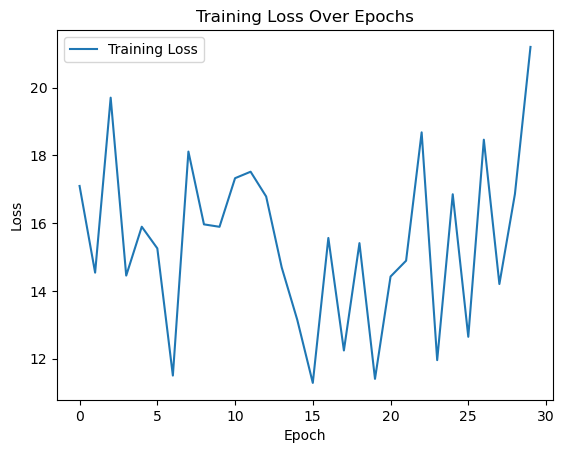

In [12]:
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Causal Inference across Realizations

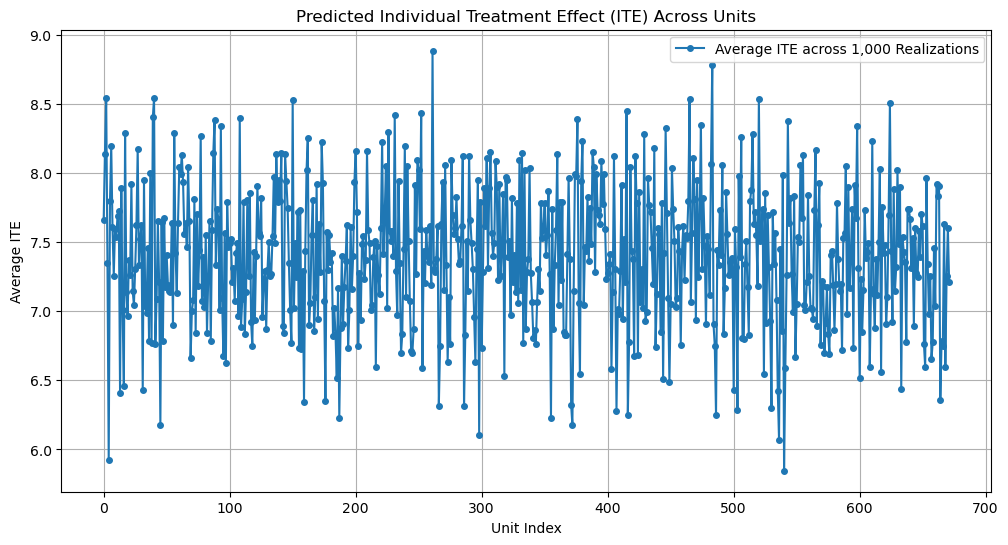

In [13]:
X_train, T_train, YF_train, _, _, _, _, _ = train_dataset.load()
X_train, T_train, YF_train = X_train.to(device), T_train.to(device), YF_train.to(device)

# X_train  : [672, 25, 1000]
# T_train  : [672, 1000]
# YF_train : [672, 1000]

ITE_accumulated = torch.zeros_like(YF_train).float()

for i in range(1000):
    realization_x = X_train[:, :, i] # [672, 25]
    realization_t = T_train[:, i].unsqueeze(1) # [672, 1]
    realization_tcf = 1 - realization_t # [672, 1]
    
    realization_Yf = YF_train[:, i].unsqueeze(1) # [672, 1]
                
    # predictions = [672, 1]
    predictions_cf = model(realization_x, realization_tcf)
    
    ITE_vals = torch.zeros_like(realization_Yf)
    ITE_vals[realization_t == 1] = realization_Yf[realization_t == 1] - predictions_cf[realization_t == 1]
    ITE_vals[realization_t == 0] = predictions_cf[realization_t == 0] - realization_Yf[realization_t == 0]    
    
    ITE_accumulated[:, i] = ITE_vals.squeeze()

ITE_avg = ITE_accumulated.mean(dim=1)
ITE_avg_np = ITE_avg.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(ITE_avg_np, label='Average ITE across 1,000 Realizations', marker='o', linestyle='-', markersize=4)
plt.xlabel('Unit Index')
plt.ylabel('Average ITE')
plt.title('Predicted Individual Treatment Effect (ITE) Across Units')
plt.legend()
plt.grid(True)
plt.show()